## Compare Non-partition performance

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%config Completer.use_jedi = False

**Extract the partitioned wave params**

In [3]:
offshore = pd.read_csv('../data/offshoreParams_partitioned.csv', index_col = 'time_a', parse_dates = True)

### Method 1: 12 hr extract
We will extract the first 12 hours from each model run and treat it as a single timeseries. <br>
For the purposes of keeping things simple we will use one of the offshore site locations.

We are hypothesising two things, one the model performs best in this time range. The second is that bias against observations is likely to be smallest.

In [4]:
#modgrps = offshore.groupby('ModelRun')

In [5]:
#allruns12hr = []
#for nm, group in modgrps:
#    allruns12hr.append(group[group['site'] == 359.0].iloc[:12])

In [6]:
#data12 = pd.concat(allruns12hr)

In [7]:
offshore.head(2)

lat_a   lon_a      hs_a    hmax_a      tp_a    tm01_a  \
time_a                                                                       
2021-01-01 00:00:00 -28.67  153.87  1.592309  2.875773  7.419529  5.744221   
2021-01-01 01:00:00 -28.67  153.87  1.616266  2.918713  7.597932  5.775996   

                       tm02_a     dpm_a        dm_a     dspr_a  ...  \
time_a                                                          ...   
2021-01-01 00:00:00  5.287222  85.26342  107.688501  51.389665  ...   
2021-01-01 01:00:00  5.293211  84.06771  105.568917  51.905817  ...   

                     tm01_sa_c  tm02_sa_c     dm_sa_c  dspr_sa_c   hs_sw_c  \
time_a                                                                       
2021-01-01 00:00:00   5.071193   4.770557  122.806554  52.115608  0.787214   
2021-01-01 01:00:00   5.047232   4.738713  123.729704  52.843299  0.814062   

                     hmax_sw_c  tm01_sw_c  tm02_sw_c     dm_sw_c  dspr_sw_c  
time_a                                                                       
2021-01-01 00:00:00   1.356680   9.645351   9.462669  106.446446  54.681822  
2021-01-01 01:00:00   1.403259   9.636326   9.457174  103.201231  54.460662  

[2 rows x 68 columns]

In [8]:
data12 = offshore

In [9]:
data12 = data12.sort_index()

In [10]:
data12 = data12[~data12.index.duplicated(keep='first')]

#### Let's checkout a data

<AxesSubplot:xlabel='time_a'>

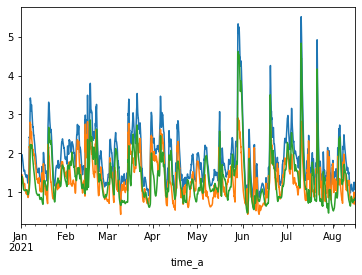

In [11]:
data12.hs_a.plot()
data12.hs_sa_a.plot()
data12.hs_sw_a.plot()

**Simplyfy:**
Use mean direction, remove fields we don't need and round data down to 2 decimal places. 
Why, becuase any more decimal places that this is superfluous information.

In [12]:
data12 = data12[['hs_a','tm02_a','tp_a','dpm_a','dm_a','hs_sa_a','tm02_sa_a','dm_sa_a','hs_sw_a','tm02_sw_a','dm_sw_a',
                'hs_b','tm02_b','tp_b','dpm_b','dm_b','hs_sa_b','tm02_sa_b','dm_sa_b','hs_sw_b','tm02_sw_b','dm_sw_b', 
                'hs_c','tm02_c','tp_c','dpm_c','dm_c','hs_sa_c','tm02_sa_c','dm_sa_c','hs_sw_c','tm02_sw_c','dm_sw_c']].round(2)
data12.head(2)

hs_a  tm02_a  tp_a  dpm_a    dm_a  hs_sa_a  tm02_sa_a  \
time_a                                                                       
2021-01-01 00:00:00  1.59    5.29  7.42  85.26  107.69     1.40       4.82   
2021-01-01 01:00:00  1.62    5.29  7.60  84.07  105.57     1.41       4.79   

                     dm_sa_a  hs_sw_a  tm02_sw_a  ...  tm02_c  tp_c   dpm_c  \
time_a                                            ...                         
2021-01-01 00:00:00   109.34     0.82       9.31  ...    5.18  6.58  127.64   
2021-01-01 01:00:00   108.41     0.86       9.31  ...    5.17  6.61  129.64   

                       dm_c  hs_sa_c  tm02_sa_c  dm_sa_c  hs_sw_c  tm02_sw_c  \
time_a                                                                         
2021-01-01 00:00:00  123.03     1.45       4.77   122.81     0.79       9.46   
2021-01-01 01:00:00  122.70     1.47       4.74   123.73     0.81       9.46   

                     dm_sw_c  
time_a                        
2021-01-01 00:00:00   106.45  
2021-01-01 01:00:00   103.20  

[2 rows x 33 columns]

### Observations
Bring in some observations for the same period this will be our labels (target parameters)

In [13]:
import sqlite3
import toolBOX

In [14]:
latestObs = pd.read_csv('../data/waveObs.csv', index_col = 0, parse_dates = True)

C:\Users\Leo\anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Filter to remove some bad obs**

In [15]:
latestObs = latestObs[latestObs['Hsig'] > 0.1]

In [16]:
Obs = latestObs[latestObs['Site'] == 'Tweed Heads Mk4']

In [17]:
Obs.index = pd.to_datetime(Obs.DateTime)

**Merge in obs from database of Obs**

In [18]:
moreObs = toolBOX.get_waveDB_xday_obs(dbpath = '../data/wave_obs.db', days = 900)

In [19]:
Obs = pd.concat([Obs, moreObs[moreObs['Site'] =='Tweed Heads Mk4'].loc[latestObs.index[-1]:]])

In [20]:
Obs = Obs[Obs.Hsig > 0.01]
Obs = Obs.drop_duplicates(keep = 'first')
Obs = Obs[~Obs.index.duplicated(keep = 'first')]
Obs = Obs.sort_index()

In [21]:
Obs = Obs[['Hsig','Hmax','Tp','Tz','Direction']]
Obs = Obs.resample('H').mean()
Obs = Obs.dropna()
Obs = Obs.round(2)

In [22]:
Obs.index = Obs.index - pd.Timedelta(hours = 10)

<AxesSubplot:xlabel='DateTime'>

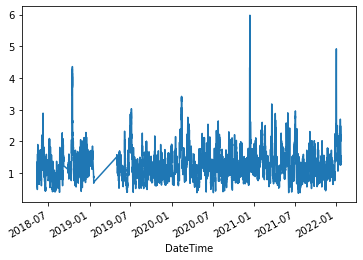

In [23]:
Obs.Hsig.plot()

### Feature Engineering
We need to prepare our data for ML models to be able to accept

In [24]:
def prepstnData(df):
    df = df.copy()
      
    df['dpm_cos'] = np.cos(np.deg2rad(df['dpm_a']))
    df['dpm_sin'] = np.sin(np.deg2rad(df['dpm_a']))
    df['dm_cos'] = np.cos(np.deg2rad(df['dm_a']))
    df['dm_sin'] = np.sin(np.deg2rad(df['dm_a']))
    df['dm_sa_cos'] = np.cos(np.deg2rad(df['dm_sa_a']))
    df['dm_sa_sin'] = np.sin(np.deg2rad(df['dm_sa_a']))
    df['dm_sw_cos'] = np.cos(np.deg2rad(df['dm_sw_a']))
    df['dm_sw_sin'] = np.sin(np.deg2rad(df['dm_sw_a']))
    
    df['dpm_cos_b'] = np.cos(np.deg2rad(df['dpm_b']))
    df['dpm_sin_b'] = np.sin(np.deg2rad(df['dpm_b']))
    df['dm_cos_b'] = np.cos(np.deg2rad(df['dm_b']))
    df['dm_sin_b'] = np.sin(np.deg2rad(df['dm_b']))
    df['dm_sa_cos_b'] = np.cos(np.deg2rad(df['dm_sa_b']))
    df['dm_sa_sin_b'] = np.sin(np.deg2rad(df['dm_sa_b']))
    df['dm_sw_cos_b'] = np.cos(np.deg2rad(df['dm_sw_b']))
    df['dm_sw_sin_b'] = np.sin(np.deg2rad(df['dm_sw_b']))
    
    df['dpm_cos_c'] = np.cos(np.deg2rad(df['dpm_c']))
    df['dpm_sin_c'] = np.sin(np.deg2rad(df['dpm_c']))
    df['dm_cos_c'] = np.cos(np.deg2rad(df['dm_c']))
    df['dm_sin_c'] = np.sin(np.deg2rad(df['dm_c']))
    df['dm_sa_cos_c'] = np.cos(np.deg2rad(df['dm_sa_c']))
    df['dm_sa_sin_c'] = np.sin(np.deg2rad(df['dm_sa_c']))
    df['dm_sw_cos_c'] = np.cos(np.deg2rad(df['dm_sw_c']))
    df['dm_sw_sin_c'] = np.sin(np.deg2rad(df['dm_sw_c']))
    
    'hs','tm02','tp','dpm','dm','hs_sa','tm02_sa','dm_sa','hs_sw','tm02_sw','dm_sw'

    df = df[['hs_a','tp_a','tm02_a','dpm_cos', 'dpm_sin', 'dm_cos', 'dm_sin', 
             'hs_sa_a','tm02_sa_a','dm_sa_cos','dm_sa_sin',
             'hs_sw_a','tm02_sw_a', 'dm_sw_cos','dm_sw_sin',
             'hs_b','hs_sa_b','hs_sw_b','dm_sin_b','dm_sa_sin_b','dm_sw_sin_b',
             'hs_c','hs_sa_c','hs_sw_c','dm_sin_c','dm_sa_sin_c','dm_sw_sin_c',]].copy()
    
    return df

In [25]:
data12_prep = prepstnData(data12)
data12_prep.head(2)

hs_a  tp_a  tm02_a   dpm_cos   dpm_sin    dm_cos  \
time_a                                                                  
2021-01-01 00:00:00  1.59  7.42    5.29  0.082634  0.996580 -0.303867   
2021-01-01 01:00:00  1.62  7.60    5.29  0.103313  0.994649 -0.268415   

                       dm_sin  hs_sa_a  tm02_sa_a  dm_sa_cos  ...  hs_sw_b  \
time_a                                                        ...            
2021-01-01 00:00:00  0.952715     1.40       4.82  -0.331173  ...     0.89   
2021-01-01 01:00:00  0.963303     1.41       4.79  -0.315815  ...     0.93   

                     dm_sin_b  dm_sa_sin_b  dm_sw_sin_b  hs_c  hs_sa_c  \
time_a                                                                   
2021-01-01 00:00:00  0.991053     0.983885     0.990795  1.62     1.45   
2021-01-01 01:00:00  0.996680     0.989925     0.984381  1.65     1.47   

                     hs_sw_c  dm_sin_c  dm_sa_sin_c  dm_sw_sin_c  
time_a                                                            
2021-01-01 00:00:00     0.79  0.838385     0.840472     0.959067  
2021-01-01 01:00:00     0.81  0.841511     0.831663     0.973579  

[2 rows x 27 columns]

**Find overlapping features (model data) and labels (observations)**

In [26]:
data = pd.merge(Obs.Hsig, data12_prep, left_index = True, right_index = True)

In [27]:
data.columns

Index(['Hsig', 'hs_a', 'tp_a', 'tm02_a', 'dpm_cos', 'dpm_sin', 'dm_cos',
       'dm_sin', 'hs_sa_a', 'tm02_sa_a', 'dm_sa_cos', 'dm_sa_sin', 'hs_sw_a',
       'tm02_sw_a', 'dm_sw_cos', 'dm_sw_sin', 'hs_b', 'hs_sa_b', 'hs_sw_b',
       'dm_sin_b', 'dm_sa_sin_b', 'dm_sw_sin_b', 'hs_c', 'hs_sa_c', 'hs_sw_c',
       'dm_sin_c', 'dm_sa_sin_c', 'dm_sw_sin_c'],
      dtype='object')

## Method 2: Timeseries Stacker

We need to test to understand whether there is enough autocorrelation. Then consider how to account for more recent timeseries information.

In [28]:
def plot_acf_colors(ax, markercolor="red", linecolor="black", facecolor="grey", barcolor="black", linewidth=1):
    """utility function to get some control over colors with  plot_acf()"""
    from statsmodels.graphics.tsaplots import plot_pacf
    from statsmodels.graphics.tsaplots import plot_acf
    from matplotlib.collections import PolyCollection, LineCollection
    for item in ax.collections:
        # change the color of the confidence interval 
        if type(item) == PolyCollection:
            item.set_facecolor(facecolor)
        # change the color of the vertical lines
        if type(item) == LineCollection:
            item.set_color(barcolor)
    # change the color of the markers
    [line.get_label() for line in ax.lines]
    for item in ax.lines:
        item.set_color(markercolor)
    # change the color of the horizontal lines
    ax.lines[0].set_color(linecolor)
    ax.lines[0].set_linewidth(linewidth)
    #ax.lines.remove(ax.lines[0])
    return ax

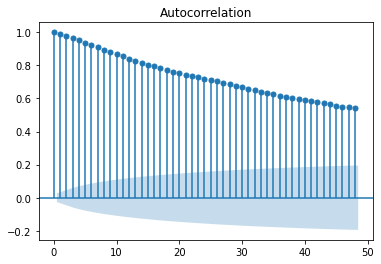

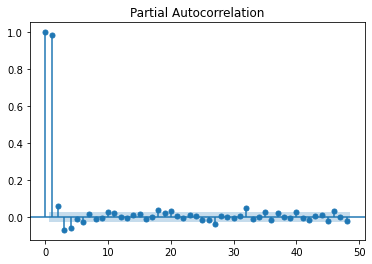

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(data['Hsig'], lags=48)
pacf = plot_pacf(data['Hsig'], lags=48)

We can observation that there is strong autocorrelation, but that diminishes, it is most strong in the first few hours (which makes sense).
Now lets look at swell from the model, is it also well correlated?

C:\Users\Leo\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


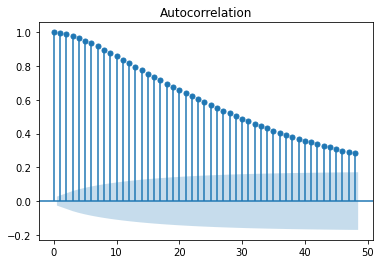

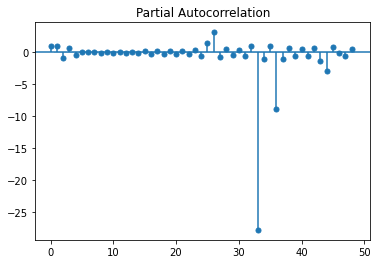

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(data['hs_sw_a'], lags=48)
pacf = plot_pacf(data['hs_sw_a'], lags=48)

It appears there is a good autocorrelation again for the first few timesteps, but that it drops away more quickly. This likely me means that is we are to stack the data (lag) to use previous timesteps we probably can't consider anything more than 12 hours, and certainly not more than 24 hours. 

In [31]:
#data['Hsig_lag6'] = data['Hsig'].shift(6)
data['Hsig_lag12'] = data['Hsig'].shift(13)
data['Hs_diff_lag12'] = data['hs_a'].shift(13) - data['Hsig'].shift(13)
#data['hs_lag6'] = data['hs'].shift(6)
#data['hs_a_lag12'] = data['hs_a'].shift(13)
#data['hs_b_lag12'] = data['hs_b'].shift(13)

<AxesSubplot:>

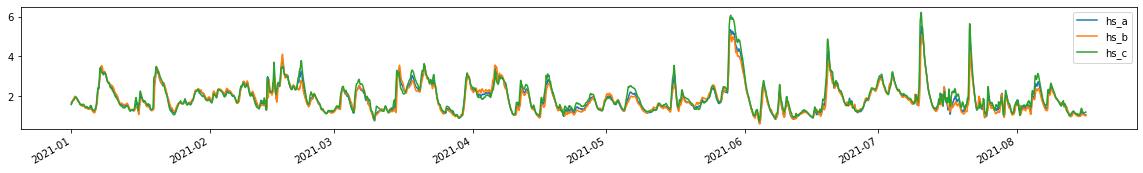

In [32]:
data[['hs_a','hs_b','hs_c']].plot(figsize = (20, 2.5))

In [33]:
data = data.dropna()

Add forecast hour

In [34]:
data['hour'] = data.index.hour

Extract independant dataset to be excluding from testing and training.

In [35]:
#ind_data = data.iloc[(int(10 * len(data.index)/100))*-1:]
#ml_data = data.iloc[:(int(10 * len(data.index)/100))*-1]

In [36]:
ind_data = data['2021-07-10 00:00':]
ml_data = data[:'2021-07-10 00:00']

## Finalising for the ML training

In [39]:
trainingColumns = ['hs_a',
                   'dm_sin',
                   'Hs_diff_lag12', 'hour']
len(trainingColumns)

4

In [40]:
#sort data down to what we need, features and labels (source and target), which in this case is univariate
labels = ml_data['Hsig'].values
features = ml_data[trainingColumns].values

**Scaling our data**

In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [42]:
from sklearn.model_selection import TimeSeriesSplit

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = False)

In [44]:
norm_f = MinMaxScaler().fit(features)
X_train = norm_f.transform(features)
norm_l = MinMaxScaler().fit(labels.reshape(-1, 1))
y_train = norm_l.transform(labels.reshape(-1, 1))

## Training

In [45]:
from sklearn.neural_network import MLPRegressor
import pickle

Guide to number of neurons

In [46]:
X_train.shape[0]/2*(X_train.shape[1]+1)

11220.0

In [47]:
6**6

46656

In [48]:
clf_mlp1 = MLPRegressor(hidden_layer_sizes = (6,6,6,6,6,6),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = False,
                                             random_state = 0)

clf_mlp2 = MLPRegressor(hidden_layer_sizes = (6,6,6,6,6,6),
                                             activation = 'relu',
                                             solver = 'adam',
                                             shuffle = False,
                                             early_stopping = True,
                                             random_state = 0)

In [49]:
X_train.shape[0]//13

345

In [50]:
tscv = TimeSeriesSplit(n_splits=int(len(X_train)//13), test_size = 2)

In [51]:
for train_index, test_index in tscv.split(X_train):
    X__train_stream, X_test_stream = X_train[train_index, :], y_train[train_index, :]
    clf_mlp1.partial_fit(X__train_stream, X_test_stream.ravel())

In [52]:
#n =   #chunk row size
#xlist_df = [X_train[i:i+n] for i in range(0,X_train.shape[0],n)]
#ylist_df = [y_train[i:i+n] for i in range(0,y_train.shape[0],n)]

In [53]:
#for i in zip(xlist_df, ylist_df):
#    clf_mlp1.partial_fit(i[0], i[1].ravel())

In [54]:
clf_mlp2.fit(X_train, y_train.ravel())

C:\Users\Leo\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(early_stopping=True, hidden_layer_sizes=(6, 6, 6, 6, 6, 6),
             random_state=0, shuffle=False)

save model for future use

In [55]:
import pickle
#pickle.dump(clf_mlp2, open("../models/twhds_mlpHs_ts.sav", 'wb'))
#pickle.dump(clf_mlp1, open("../models/twhds_mlpHs.sav", 'wb'))

In [56]:
import xgboost

In [57]:
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

In [58]:
X = pd.DataFrame(X_train)
X.columns = trainingColumns

In [59]:
X_train.shape

(4488, 4)

In [60]:
xgb = XGBRegressor( n_estimators=2000)
xgb.fit(X, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Make Prediction

In [61]:
ind_data = ind_data[~ind_data.index.duplicated(keep='first')]

In [62]:
n = 12  #chunk row size
list_df = [ind_data[i:i+n] for i in range(0,ind_data.shape[0],n)]

In [63]:
mydList = []
for d in list_df:
    hs_pred = norm_l.inverse_transform(clf_mlp1.predict(norm_f.transform(d[trainingColumns].values)).reshape(-1,1))
    hs_pred2 = norm_l.inverse_transform(clf_mlp2.predict(norm_f.transform(d[trainingColumns].values)).reshape(-1,1))
    hs_pred_xbg = norm_l.inverse_transform(xgb.predict(norm_f.transform(d[trainingColumns].values)).reshape(-1,1))
    nd = d.copy()
    nd['mlp'] = hs_pred
    nd['mlp2'] = hs_pred2
    nd['xbg'] = hs_pred_xbg
    mydList.append(nd)

In [64]:
fdata = pd.concat(mydList)

In [65]:
#hs_pred = norm_l.inverse_transform(clf_mlp1.predict(norm_f.transform(ind_data[trainingColumns].values)).reshape(-1,1))
#hs_pred2 = norm_l.inverse_transform(clf_mlp2.predict(norm_f.transform(ind_data[trainingColumns].values)).reshape(-1,1))
#hs_pred_xbg = norm_l.inverse_transform(xgb.predict(norm_f.transform(ind_data[trainingColumns].values)).reshape(-1,1))

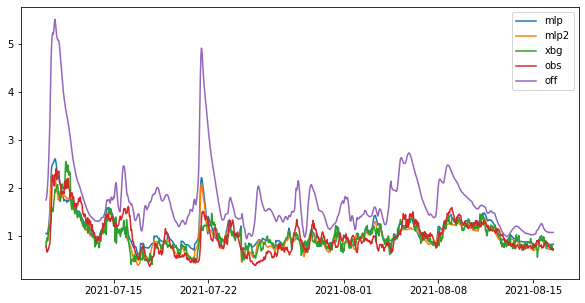

In [66]:
plt.figure(figsize = (10, 5))
plt.plot(fdata.index, fdata.mlp, label = 'mlp')
plt.plot(fdata.index, fdata.mlp2, label = 'mlp2')
plt.plot(fdata.index, fdata.xbg, label = 'xbg')
plt.plot(ind_data.index, ind_data.Hsig, label = 'obs')
plt.plot(ind_data.index, ind_data.hs_a, label = 'off')
plt.legend()

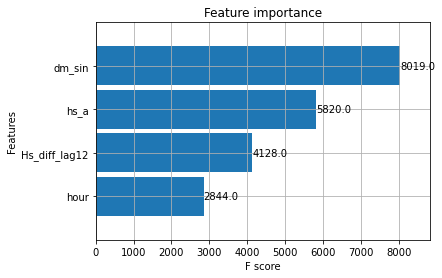

In [67]:
_ = plot_importance(xgb, height=0.9)

## Compare Performance

We also have results for a SWAN model for comparison. This model was forced by the AUSWAVE-G3 experimental model (using wave parameters to create a JONSWAP spectrum).

In [68]:
wbSWAN = pd.read_csv("../data/SWAN_wb_results_JONSWAP.csv", parse_dates = True, index_col = 0)
wbSWAN = wbSWAN.drop_duplicates()
wbSWAN.head(2)

%       Time     Hsig    Tm02     Dir  PkDir  Watlev   Hswell  \
Date/Time                                                                   
2021-01-01    20210101.0  1.56653  5.9332  86.157   87.5    0.86  0.17215   
2021-01-01    20210101.0  1.42091  5.8340  86.885   87.5    0.86  0.15517   

            Tp_smoothed  site        site_name         lon        lat  \
Date/Time                                                               
2021-01-01       7.4409     0     Brisbane WRB  153.631555 -27.487153   
2021-01-01       7.4317     1   Gold Coast WRB  153.442502 -27.963965   

                      run  
Date/Time                  
2021-01-01  20210101_0000  
2021-01-01  20210101_0000

In [69]:
modgrps = wbSWAN.groupby('run')

In [70]:
allruns12hr = []
for nm, group in modgrps:
    allruns12hr.append(group[group['site_name']==' Tweed Heads WRB'].iloc[:12])
wbSWAN = pd.concat(allruns12hr)

In [71]:
wbSWAN.index = wbSWAN.index - pd.Timedelta(hours=10)

In [72]:
wbSWAN =wbSWAN[ind_data.index[0]:ind_data.index[-1]]

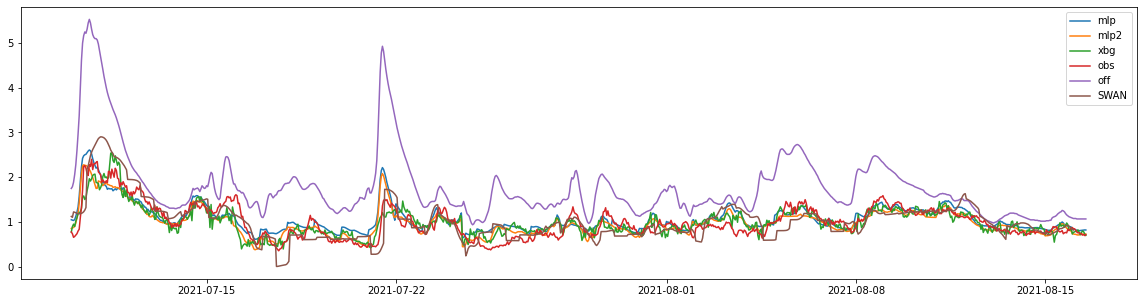

In [73]:
plt.figure(figsize =(20, 5))
plt.plot(fdata.index, fdata.mlp, label = 'mlp')
plt.plot(fdata.index, fdata.mlp2, label = 'mlp2')
plt.plot(fdata.index, fdata.xbg, label = 'xbg')
plt.plot(ind_data.index, ind_data.Hsig, label = 'obs')
plt.plot(ind_data.index, ind_data.hs_a, label = 'off')
plt.plot(wbSWAN.index, wbSWAN.Hsig, label = 'SWAN')
plt.legend()

In [74]:
import cal_stats

In [75]:
s = pd.merge(ind_data.Hsig,wbSWAN.Hsig, right_index = True, left_index = True)

In [76]:
cal_stats.all_stats(s.Hsig_y.values, s.Hsig_x.values)

{'Bias': 0.02,
 'Root Mean Squared Error': 0.26,
 'Scatter Index': 26.1,
 'Coefficient of Determination': 0.66,
 'Coefficient of Efficiency': 0.51,
 'Correlation Coefficient': 0.82,
 'Index of Agreement': 0.89}

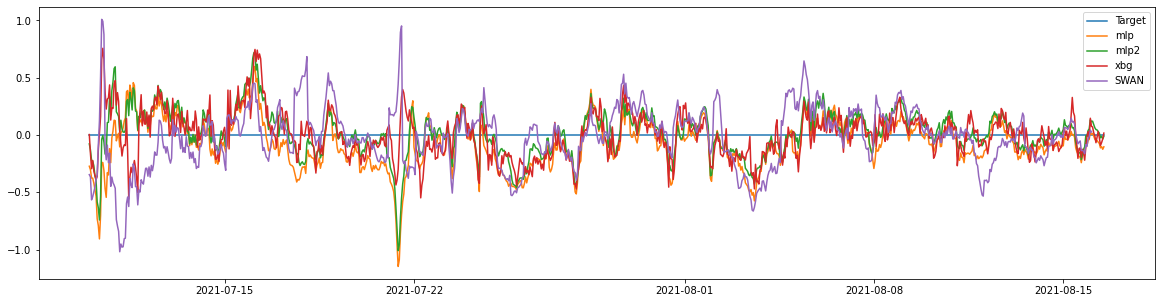

In [77]:
plt.figure(figsize =(20, 5))
plt.plot(fdata.index, ind_data.Hsig - ind_data.Hsig, label = 'Target')
plt.plot(fdata.index, ind_data.Hsig - fdata.mlp, label = 'mlp')
plt.plot(fdata.index, ind_data.Hsig - fdata.mlp2, label = 'mlp2')
plt.plot(fdata.index, ind_data.Hsig - fdata.xbg, label = 'xbg')
plt.plot(s.index, s.Hsig_x - s.Hsig_y, label = 'SWAN')
plt.legend()

In [78]:
import plotly.express as px
import plotly.graph_objects as go

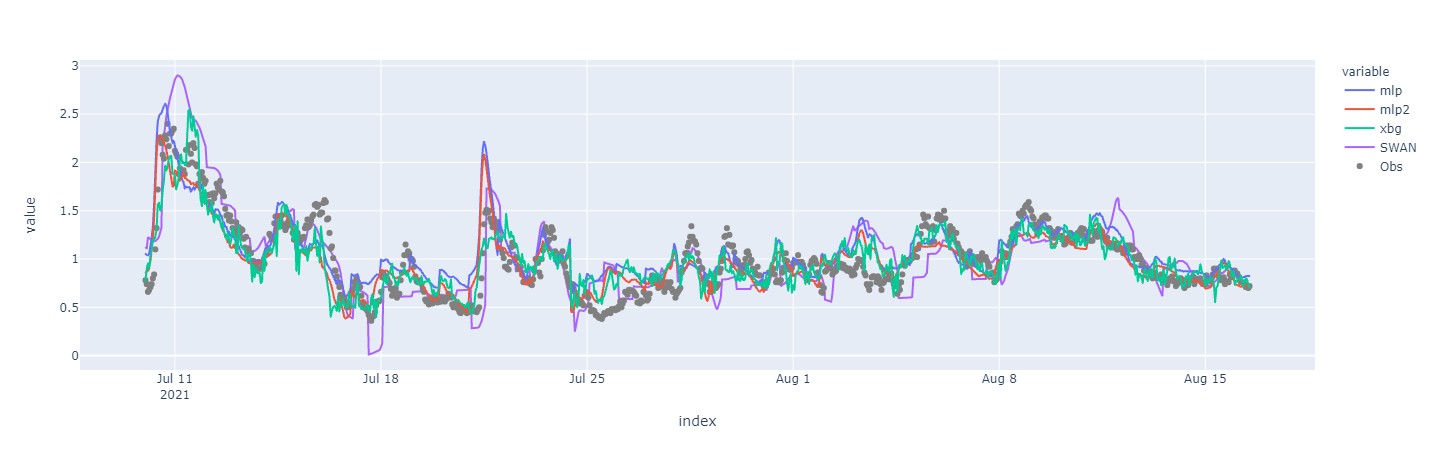

In [79]:
fig = px.line(fdata, x=fdata.index, y=['mlp','mlp2','xbg'])
fig.add_trace(go.Scatter(x = wbSWAN.index, y = wbSWAN.Hsig, name = 'SWAN'))
fig.add_trace(go.Scatter(x = fdata.index, y = fdata.Hsig, name = 'Obs', mode = "markers", marker_color='grey'))
fig.show()

In [80]:
start_d = '2021-07-10'
end_d = '2021-07-30'

In [85]:
cal_stats.all_stats(fdata['mlp'].loc[start_d:end_d], fdata.loc[start_d:end_d].Hsig)

{'Bias': 0.09,
 'Root Mean Squared Error': 0.26,
 'Scatter Index': 25.0,
 'Coefficient of Determination': 0.7,
 'Coefficient of Efficiency': 0.66,
 'Correlation Coefficient': 0.84,
 'Index of Agreement': 0.9}

In [86]:
cal_stats.all_stats(fdata['mlp2'].loc[start_d:end_d], fdata.loc[start_d:end_d].Hsig)

{'Bias': -0.02,
 'Root Mean Squared Error': 0.23,
 'Scatter Index': 23.1,
 'Coefficient of Determination': 0.74,
 'Coefficient of Efficiency': 0.74,
 'Correlation Coefficient': 0.86,
 'Index of Agreement': 0.92}

In [87]:
fdata['mlp'].loc[start_d:end_d].to_csv("../data/MLP_hs_obs.csv")